## Strain data analysis

In [43]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
# import statsmodels.api as sm
# from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import seaborn as sns

In [44]:
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.geometry.hypersphere import Hypersphere
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

np.random.seed(1)
gs.random.seed(1000)

In [45]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [46]:
def pyriemann_clusters(data):
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    
    kmeans = Kmeans(3, metric='riemann', tol=1e-3, init='random')
    kmeans.fit(data)
    labels = kmeans.predict(data)
    centroids = kmeans.centroids
    print(labels)


#     Find optimal number of regimes
 
#     for k in K:
#         kmeans = KMeans(k, 'riemann', tol=1e-3, init='random')
#         kmeans.fit(data)
#         labels = kmeans.predict(data)
#         centroids = kmeans.centroids
#         print(labels)
        
#         distortions.append(sum(np.min(cdist(data, kmeans.centroids, 'euclidean'), axis=1)) / np.array(data).shape[0])
#         inertias.append(kmeans.inertia_)
#         mapping1[k] = sum(np.min(cdist(data, kmeans.centroids, 'euclidean'), axis=1)) / np.array(data).shape[0]
#         mapping2[k] = kmeans.inertia_
        
#     #   The elbow method for optimal number of clusters
#     plt.plot(K, inertias, 'bx-')
#     plt.xlabel('Values of K')
#     plt.ylabel('Distortion')
#     plt.title('The Elbow Method using Distortion')
#     plt.show()
    
    return labels

In [47]:
from sklearn.cluster import KMeans
from pyriemann.clustering import Kmeans
from sklearn import metrics
from scipy.spatial.distance import cdist

def cov_cluster(data, wsize, dist_metric):
    
    winsize = wsize
    start = 0
    covmat = []
    covar = []
    columns = data.columns
    dim = len(columns) - 1
    cluster_idx = []
 
    while start+winsize < len(data)-1:
        cluster_idx.append(start)
#         print(f"Data shape: {data.shape}")
        data_batch = data[start: start + winsize]
#         print(f"Data batch: {data_batch.shape}")
        ls_data_batch = []
        
        for i in range(len(columns)):
            ls_data_batch.append(data_batch[columns[i]].values.tolist())

        cov = np.cov(np.array(ls_data_batch))
#         print(f"Covariance of {columns[14]} with other variables: {cov[14]}")
#         flat_cov = np.concatenate(cov).ravel().tolist()
        upper = np.triu(cov, k=0)
#         print(f"Length of Cov matrix: {len(upper[upper!=0])}")
        mask = np.triu_indices(dim)
        newupp = list(upper[mask])
        upp = list(upper[upper!=0])
        
#         mean_v = list(np.mean(np.array(ls_data_batch), axis=1))
        
        feat = stats.describe(np.array(ls_data_batch), axis=1)
        mean_val = feat.mean.tolist()
        skewness = feat.skewness.tolist()
        kurtosis = feat.kurtosis.tolist()
        
#         plt.plot(helper.normalize(newupp, 'std'))
#         plt.show()
        mix_feat = newupp 
#         print(f"Length of features pool: {len(mix_feat)}")
        covmat.append(mix_feat)
        covar.append(cov)
#         print(covmat)
        start = start + winsize
    
        distortions = []
        inertias = []
        mapping1 = {}
        mapping2 = {}
        K = (2, 6)
    
    if dist_metric == 'Euclidean':
        
        kmeans = KMeans(n_clusters=3, random_state=0, n_init=1).fit(covmat)
        clusters = list(kmeans.labels_)
        print(f"Clusters: {list(kmeans.labels_)}")
    
#     for k in K:
#             kmeans = KMeans(n_clusters=k, random_state=0, n_init=1).fit(covmat)
#             clusters = list(kmeans.labels_)
#             print(f"Clusters: {list(kmeans.labels_)}")
        
#             distortions.append(sum(np.min(cdist(covmat, kmeans.cluster_centers_, 'mahalanobis'), axis=1)) / np.array(covmat).shape[0])
#             inertias.append(kmeans.inertia_)
#             mapping1[k] = sum(np.min(cdist(covmat, kmeans.cluster_centers_, 'mahalanobis'), axis=1)) / np.array(covmat).shape[0]
#             mapping2[k] = kmeans.inertia_
        
#         #   The elbow method for optimal number of clusters
#         plt.plot(K, inertias, 'bx-')
#         plt.xlabel('Values of K')
#         plt.ylabel('Distortion')
#         plt.title('The Elbow Method using Distortion')
#         plt.show()
    
    else:
#         clusters = cluster(np.array(covmat))
        clusters = pyriemann_clusters(np.array(covar))
#     
#     print(f"Clusters indecis: {cluster_idx}")
    return clusters, cluster_idx

In [48]:
def ClaSP(time_series, tcps):
    
    plt.plot(time_series)
    # plt.show()
    clasp = BinaryClaSPSegmentation()
    regimes = clasp.fit_predict(time_series)
    clasp.plot(gt_cps=tcps, heading="Segmentation", ts_name="ACC", file_path="ts_segmentation.png")
    
    return regimes

In [49]:
# from claspy.segmentation import BinaryClaSPSegmentation
# from claspy.data_loader import load_tssb_dataset

# dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX", )).iloc[0, :]
# print(dataset)
# print(true_cps)
# clusters = ClaSP(time_series, true_cps)
# print(clusters)

In [66]:
# data = pd.read_csv(r'data/moxa_data_D.csv')
data = pd.read_csv(r'../datasets/synthetic_datac.csv')

In [52]:
# start, end = '2016-06-15', '2016-12-30'
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]
# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z1      1100 non-null   float64
 1   Z2      1100 non-null   float64
 2   Z3      1100 non-null   float64
 3   Z4      1100 non-null   float64
 4   Z5      1100 non-null   float64
dtypes: float64(5)
memory usage: 51.6 KB


In [53]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

In [54]:
data.isna().sum().sum()

0

In [55]:
data = data.apply(normalize)
data.head(100)

,Z1,Z2,Z3,Z4,Z5
0,0.392774,0.384298,0.228360,0.386939,0.502451
1,0.516602,0.511224,0.436225,0.583319,0.502090
2,0.536742,0.531345,0.520703,0.516810,0.406364
3,0.621037,0.605209,0.507146,0.618633,0.477838
4,0.491270,0.484192,0.060076,0.472417,0.515868
...,...,...,...,...,...
95,0.497890,0.488537,0.476392,0.419923,0.527912
96,0.391257,0.374165,0.444695,0.379999,0.513682
97,0.427033,0.419451,0.565895,0.445341,0.431990
98,0.461512,0.462201,0.469378,0.426005,0.405188


In [56]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

In [57]:
# data.isna().sum().sum()

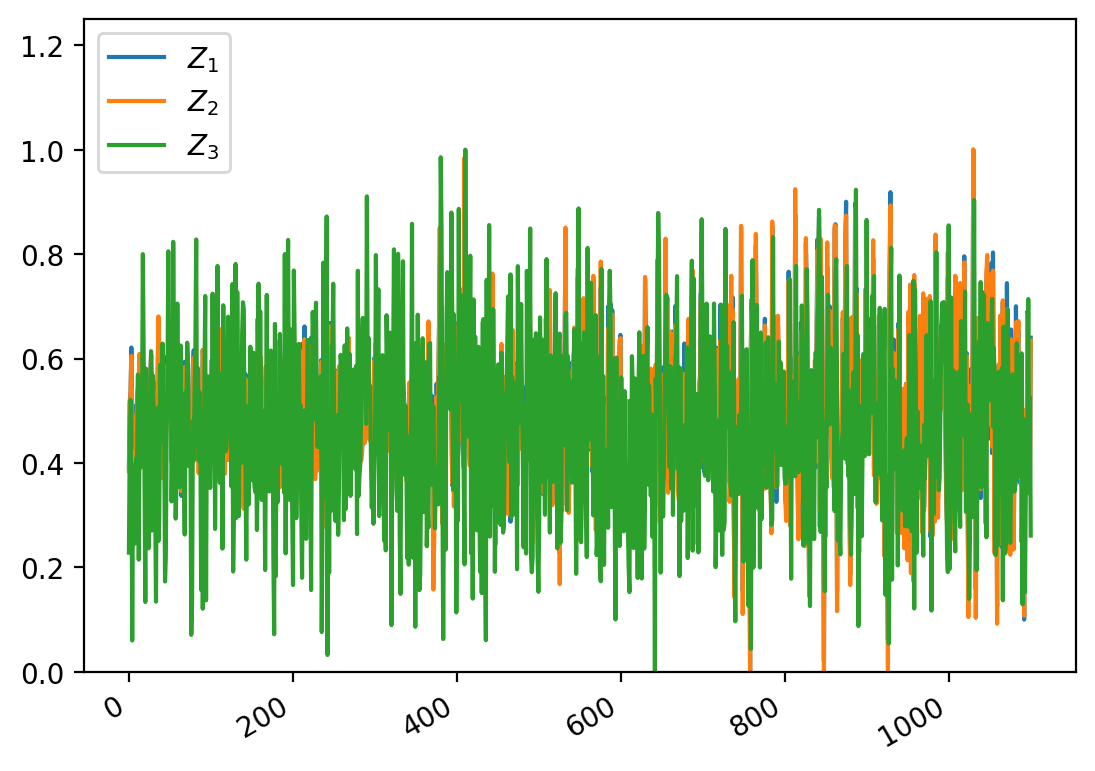

In [67]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'gw_west', 'gw_south', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z3']

for i in toplot:
    data[i].plot(use_index=True)
    plt.legend(toplot)


plt.ylim(0, 1.250)
plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [59]:
ts = np.stack((time_series, np.random.normal(0, 1, len(time_series))), axis=1)
ts = pd.DataFrame(ts, columns=['t1', 't2'])
ts.shape
# time_series.shape

(3092, 2)

In [60]:
winsize = 60 # 85
metricE = 'Euclidean'
metricR = 'Riemannian'
clusters, cluster_idx = cov_cluster(data, winsize, metricR)

[1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0]


In [61]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
print(len(clusters_extended), data.shape)

1080 (1100, 5)


In [62]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

In [63]:
# dfs = []
# for c in range(len(list(set(clusters)))):
#         dfs.append(datanew.loc[datanew['Clusters'] == list(set(clusters))[c]])

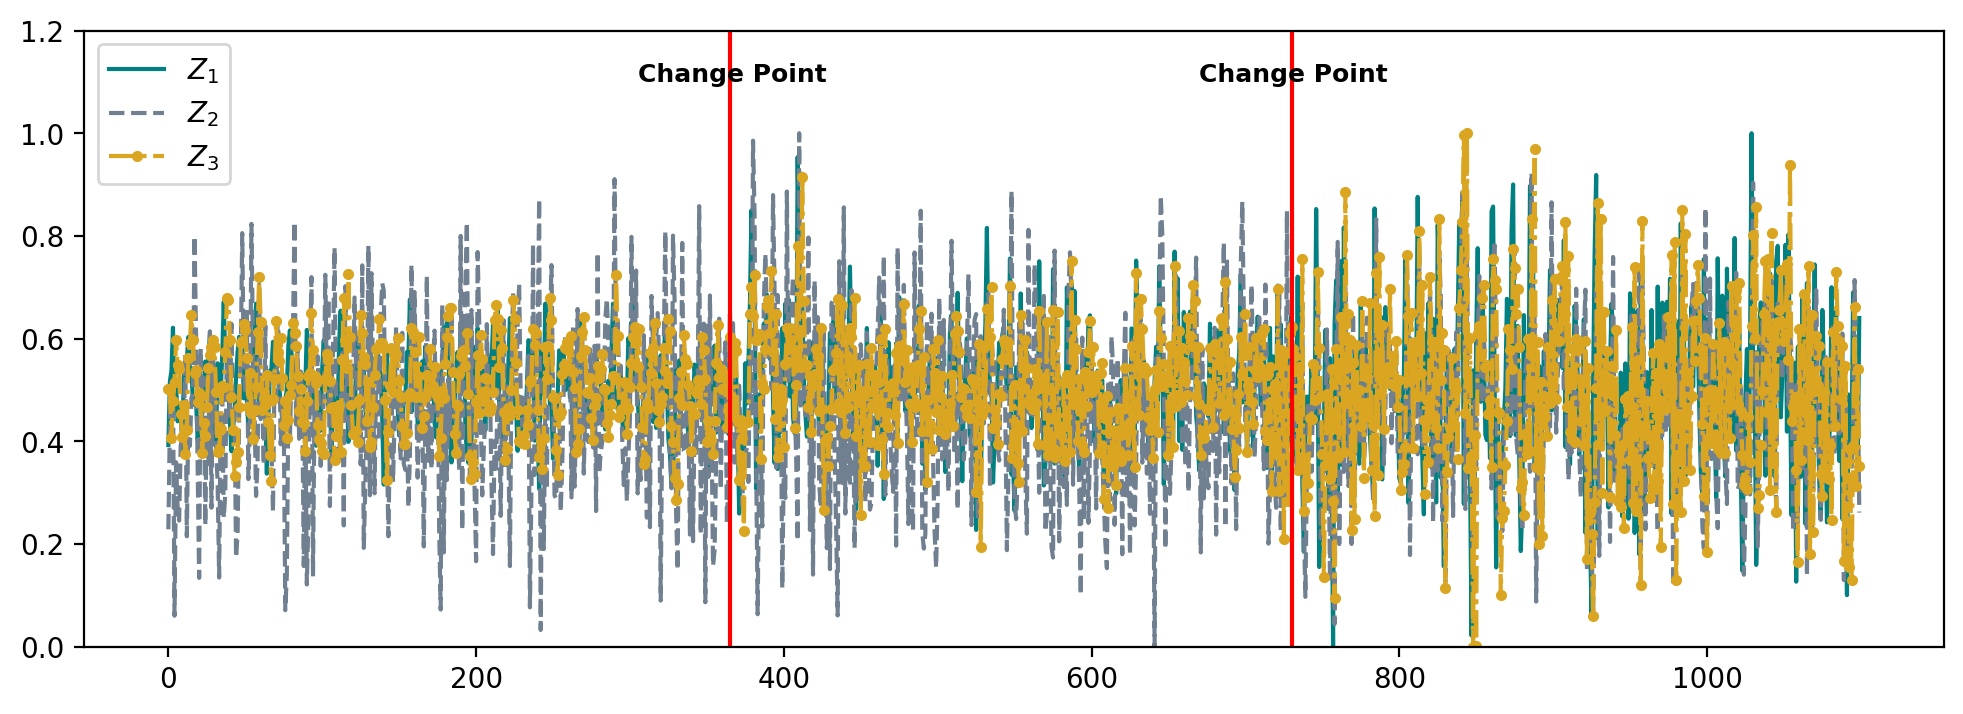

In [71]:
# toplot = [ 'rain','strain_ns_corrected', 'tides_ns', 'temperature_outside', 'pressure_outside', 'gw_west']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'gw_west', 'gw_south', 'strain_ns_corrected']
toplot = ['Z1', 'Z3', 'Z5']
# toplot = ['Hs', 'P', 'W' ]
colors = ['r', 'g', 'b', 'y', 'c']
# toplot = ['t1', 't2']

t = np.arange(0, cluster_idx[-1]+winsize)
start = 0


# for c in range(len(clusters)):
    
#     if clusters[c] == 0:
#             marker = '-'
#     elif clusters[c] == 1:
#             marker = '-'
#     elif clusters[c] == 2:
#             marker = '-'
#     for i in toplot:
        
#         data[i].plot(use_index=True)
#         plt.legend(toplot)
# #         plt.plot(t[start: start+winsize], data[toplot[i]].values[start: start + winsize], colors[i]+marker)
# #         plt.plot(t[start: start + winsize], data[toplot[i+1]].values[start: start + winsize], color)
# #         plt.plot(t[start: start + winsize], data[toplot[i+2]].values[start: start + winsize], color)
        
#     start = start + winsize


plt.figure(figsize=(12, 4))
col = ['teal', 'slategrey', 'goldenrod']
mark = ['-', '--', '.-.']
for i, v in enumerate(toplot):
        # data.plot(use_index=True, figsize=(10, 3), linewidth=0.75, alpha=0.66, color=['green', 'blue', 'red'])
        plt.plot(data[v], mark[i], color=col[i])
#         plt.plot(t[start: start+winsize], data[toplot[i]].values[start: start + winsize], colors[i]+marker)
#         plt.plot(t[start: start + winsize], data[toplot[i+1]].values[start: start + winsize], color)
#         plt.plot(t[start: start + winsize], data[toplot[i+2]].values[start: start + winsize], color)

plt.legend(toplot)
for c in range(len(cluster_idx)):
        pass
    # val = cluster_idx[c]
    # if clusters[c] == 0:
    #     for v in range(winsize):
    #         plt.axvline(val+v, color="green", alpha=0.1)
    # if clusters[c] == 1:
    #     for v in range(winsize):
    #         plt.axvline(val+v, color="white", alpha=0.00)
    # if clusters[c] == 2:
    #     for v in range(winsize):
    #         plt.axvline(val+v, color="red", alpha=0.1)
plt.axvline(x=365, color='red')
plt.text(305, 1.10, 'Change Point', fontsize=9.0, fontweight='bold')
plt.axvline(x=730, color='red')
plt.text(670, 1.10, 'Change Point', fontsize=9.0, fontweight='bold')
plt.ylim(0, 1.20)
# plt.gcf().autofmt_xdate()
plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'], loc='upper left', fontsize=6, prop=dict(weight='bold'))
# plt.legend(['GW$_{mb}$', 'GW$_{sg}$', 'T$_{out}$', 'Strain$_{ew}$', 'Strain$_{ns}$'], loc='upper right')
plt.savefig("../res/synregimes1.png")
plt.show()